# Attention Model from scratch: tutorial

feat. Heterogeneuous Attention Model


Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from rl4co.envs import PDPEnv
from rl4co.utils.lightning import get_lightning_device
from rl4co.models.rl.reinforce import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset
# from rl4co.models import AttentionModel, AttentionModelPolicy # in this notebook, we make them from scratch.uncomment this line if you want to use the original ones.
from rl4co.models.nn.env_embedding import env_init_embedding
from rl4co.models.nn.graph import GraphAttentionEncoder
from rl4co.models.zoo.am.decoder import Decoder
from rl4co.models.nn.utils import get_log_likelihood
from rl4co.utils.pylogger import get_pylogger
from rl4co.models.nn.attention import LogitAttention
from rl4co.models.nn.env_context import env_context
from rl4co.models.nn.env_embedding import env_dynamic_embedding
from rl4co.models.nn.utils import decode_probs
from rl4co.tasks.rl import RL4COLitModule

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment
We test on a simple TSP environment

In [2]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    td.set("action", actions)
    return td

In [3]:
env = PDPEnv(num_loc=20)

td = env.reset(batch_size=[5])
init_td = td.clone()
td = rollout(env, td, random_policy)
env.get_reward(td, td['action'])

tensor([-11.6646,  -9.9489, -10.6282,  -8.3801, -10.9230])

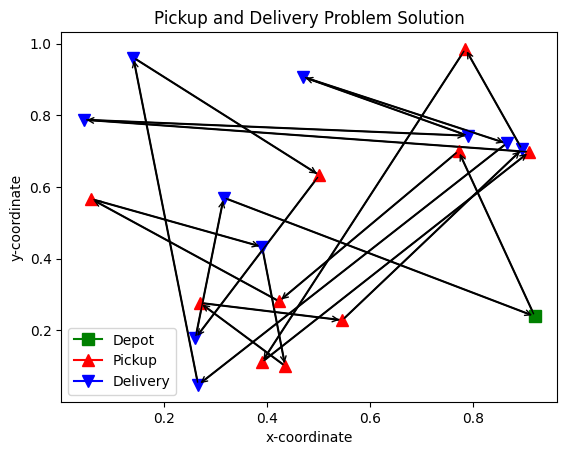

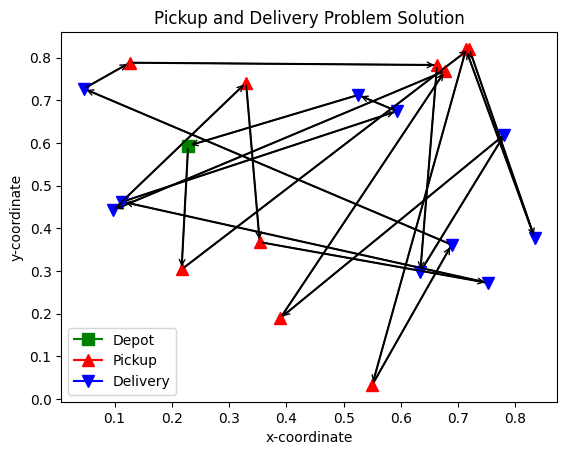

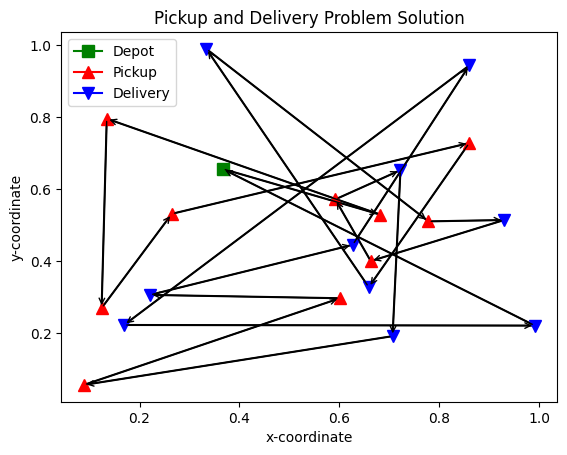

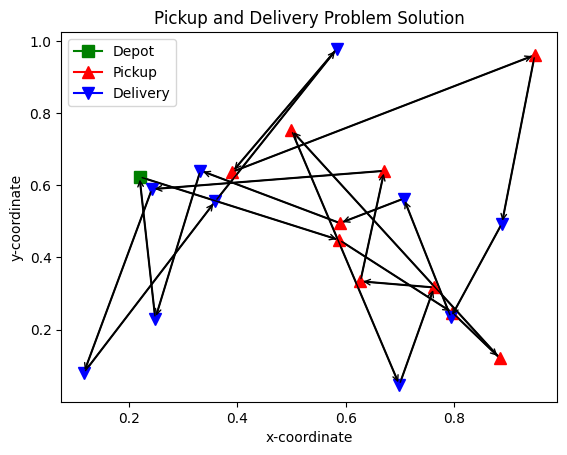

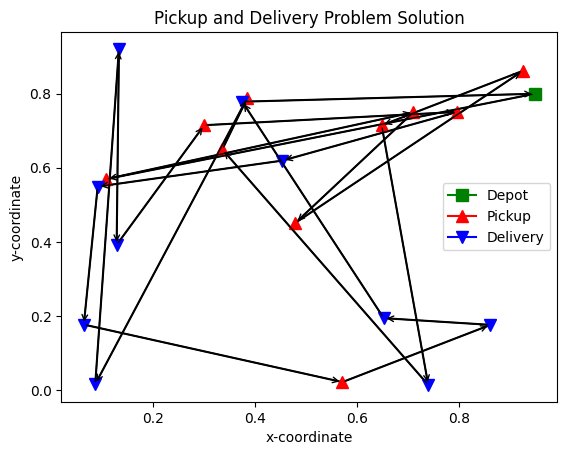

In [4]:
# Plot 
render_td = td.clone()
render_td.set('to_deliver', init_td['to_deliver'])

for i in range(5):
    env.render(render_td[i])

## Encoder

We use a `GraphHeterogeneousAttentionEncoder` that is shared with most models (we just import it from RL4CO)

In [5]:
from rl4co.models.zoo.ham.encoder import GraphHeterogeneousAttentionEncoder
?? GraphHeterogeneousAttentionEncoder

Init signature:
 GraphHeterogeneousAttentionEncoder(
    num_heads,
    embed_dim,
    num_layers,
    node_dim=None,
    normalization='batch',
    feed_forward_hidden=512,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made

## Decoder 

We can also simply import it from AM

In [6]:
from rl4co.models.zoo.am.decoder import Decoder
?? Decoder

Init signature:  Decoder(env, embedding_dim, num_heads, **logit_attn_kwargs)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in trai

## Policy

The policy takes an initial state and gives back collected rewards and log likelihood. We can also return extras such as actions

In [7]:
from rl4co.models.zoo.am.policy import AttentionModelPolicy

?? AttentionModelPolicy

Init signature:
 AttentionModelPolicy(
    env: torchrl.envs.common.EnvBase,
    encoder: torch.nn.modules.module.Module = None,
    decoder: torch.nn.modules.module.Module = None,
    embedding_dim: int = 128,
    num_encode_layers: int = 3,
    num_heads: int = 8,
    normalization: str = 'batch',
    mask_inner: bool = True,
    force_flash_attn: bool = False,
    train_decode_type: str = 'sampling',
    val_decode_type: str = 'greedy',
    test_decode_type: str = 'greedy',
    **unused_kw,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def f

In [8]:
# Load environment with test data
env = PDPEnv()

# Encoder params
embedding_dim = 128
num_layers = 3
num_heads = 8

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

# NOTE: declaring encoder / decoder will override the default ones in the policy
policy = AttentionModelPolicy(
    env,
    encoder=GraphHeterogeneousAttentionEncoder( # override the encoder with our own
        num_heads=num_heads,
        embed_dim=embedding_dim,
        num_layers=num_layers,
    ),
    decoder=Decoder(env, embedding_dim=embedding_dim, num_heads=num_heads),
    num_heads=num_heads,
    embedding_dim=embedding_dim,

).to("cuda")

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling", return_actions=False)

print(out)

{'reward': tensor([ -8.2184,  -8.0639, -13.5098, -11.1787,  -8.2495, -10.5342, -10.9920,
         -9.2387,  -8.1159,  -9.8008, -11.3659, -10.3443, -10.1966, -10.5551,
         -9.6988, -10.1657, -11.1200, -10.2846, -12.1888, -10.7633,  -9.3012,
        -12.0977, -10.4513,  -9.4379,  -8.2392,  -9.5261,  -9.9632, -12.2036,
        -13.6699, -12.1570,  -9.5701,  -9.7223,  -8.6718, -11.8280, -11.8715,
         -9.8393, -10.2590, -10.0419, -12.9578, -11.5082, -10.8490, -10.1921,
         -8.7125, -10.2728,  -9.7845, -10.5032, -10.9860, -11.5729,  -8.0300,
        -11.0459, -12.0199, -11.9885, -10.7297, -11.2672, -11.3794, -11.5654,
         -9.8105,  -8.3560, -10.3867, -11.0759,  -9.8470, -11.9377,  -9.9072,
         -9.7329], device='cuda:0'), 'log_likelihood': tensor([-33.1998, -31.3944, -28.6096, -34.0984, -32.7762, -36.4634, -31.2617,
        -24.9565, -26.2652, -32.9168, -27.9004, -34.1342, -34.8958, -30.6016,
        -35.2125, -31.8224, -29.8319, -22.9636, -32.9132, -31.7582, -30.7855

## Create full AM: `env` + `policy` + `baseline`

The full model includes REINFORCE baseline and the policy: it contains the logic for training. 
For example, in REINFORCE with a rollout baseline, a copy of the policy is used as the baseline to calculate the advantages and it is updated only when the new policy is actually better than the baseline.

In [9]:
class AttentionModel(nn.Module):
    def __init__(self, env, policy=None, baseline=None):
        """
        Attention Model for neural combinatorial optimization based on REINFORCE
        Based on Wouter Kool et al. (2018) https://arxiv.org/abs/1803.08475
        Refactored from reference implementation: https://github.com/wouterkool/attention-learn-to-route

        Args:
            env: TorchRL Environment
            policy: Policy
            baseline: REINFORCE Baseline
        """
        super().__init__()
        self.env = env
        self.policy = AttentionModelPolicy(env) if policy is None else policy
        self.baseline = (
            WarmupBaseline(RolloutBaseline()) if baseline is None else baseline
        )

    def forward(self, td: TensorDict, phase: str = "train", **policy_kwargs):
        # Evaluate model, get costs and log probabilities
        out = self.policy(td, phase, **policy_kwargs)

        if phase == "train":
            # Evaluate baseline
            bl_val, bl_loss = self.baseline.eval(td, -out["reward"])

            # Calculate loss
            advantage = -out["reward"] - bl_val
            reinforce_loss = (advantage * out["log_likelihood"]).mean()
            loss = reinforce_loss + bl_loss
            out.update(
                {
                    "loss": loss,
                    "reinforce_loss": reinforce_loss,
                    "bl_loss": bl_loss,
                    "bl_val": bl_val,
                }
            )

        return out

    def setup(self, lit_module):
        # Make baseline taking model itself and train_dataloader from model as input
        self.baseline.setup(
            self.policy,
            lit_module.val_dataloader(),
            self.env,
            device=get_lightning_device(lit_module),
        )

    def on_train_epoch_end(self, lit_module):
        self.baseline.epoch_callback(
            self.policy,
            lit_module.val_dataloader(),
            lit_module.current_epoch,
            self.env,
            device=get_lightning_device(lit_module),
        )

In [10]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([ -9.0773,  -7.8380, -10.0075,  -9.4466, -10.5631, -11.6343, -11.0994,
        -11.3545,  -9.2856, -11.9371, -11.5970,  -9.8030, -10.9730,  -9.5345,
        -10.1432, -10.5737,  -9.5070,  -8.9634, -12.5957, -10.0504,  -9.2335,
        -13.0055, -11.1421, -10.2200,  -9.0601,  -9.1957, -11.7697, -12.1960,
        -12.7312, -10.2524, -10.6295, -10.0243, -11.0673,  -9.3574, -10.7588,
        -10.2705, -11.3240, -11.1535, -10.4334,  -9.8128, -10.7841, -11.8984,
        -11.2623,  -9.1455, -10.2528, -10.2235, -11.0469,  -9.9854,  -9.3484,
        -11.1727, -10.0797, -11.4722, -10.7164, -10.4721, -12.2945, -11.2683,
         -9.0164,  -8.2211,  -9.6104,  -9.4517, -10.9985, -12.6153, -10.3401,
         -9.1320], device='cuda:0'), 'log_likelihood': tensor([-28.5992, -30.5712, -34.8998, -21.1001, -32.7600, -32.7188, -31.7797,
        -21.9946, -25.8865, -35.3820, -31.8267, -32.0161, -30.6986, -28.7587,
        -38.0673, -35.3718, -30.0221, -32.9595, -23.4228, -33.1823, -31.5984

## Lightning Module

Same as before, let's simply import it from RL4CO: no need to reinvet the wheel!

In [11]:
from rl4co.tasks.rl import RL4COLitModule
?? RL4COLitModule

Init signature:
 RL4COLitModule(
    cfg: omegaconf.dictconfig.DictConfig,
    env: torchrl.envs.common.EnvBase = None,
    model: torch.nn.modules.module.Module = None,
)
Docstring:      Hooks to be used in LightningModule.
Source:        
class RL4COLitModule(LightningModule):
    def __init__(self, 
                 cfg: DictConfig, 
                 env: EnvBase = None,
                 model: nn.Module = None):
        """
        Base LightningModule for Neural Combinatorial Optimization
        Args:
            cfg: Hydra config
            env: Environment to use overridding the config. If None, instantiate from config
            model: Model to use overridding the config. If None, instantiate from config
        """

        if cfg.get("train", {}).get("disable_profiling", True):
            # Disable profiling executor. This reduces memory and increases speed.
            # https://github.com/HazyResearch/safari/blob/111d2726e7e2b8d57726b7a8b932ad8a4b2ad660/train.py#LL124-L

## Main training setup

In [12]:

config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "batch_size": 512,
        },
        "optimizer": {
            "_target_": "torch.optim.Adam",
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)

lit_module = RL4COLitModule(config, env, model)

# lit_module = RL4COLitModule(env, model, config)

## Fit model

In [13]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=1, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | PDPEnv         | 0     
1 | model | AttentionModel | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.903     Total estimated model params size (MB)
2023-05-17 15:23:38.156159: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 15:23:38.175261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s, v_num=3, train/reward_step=-6.16, train/loss_step=-.170, val/reward_step=-5.95, val/reward_epoch=-5.92, train/reward_epoch=-6.99, train/loss_epoch=1.170]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 196/196 [00:10<00:00, 19.06it/s, v_num=3, train/reward_step=-6.16, train/loss_step=-.170, val/reward_step=-5.95, val/reward_epoch=-5.92, train/reward_epoch=-6.99, train/loss_epoch=1.170]


In [14]:
trainer.test(lit_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 55.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/reward_epoch     │    -5.901882648468018     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward_epoch': -5.901882648468018}]

## Analyze results

In [15]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy", return_actions=True)
out['reward'].mean()

tensor(-6.0125, device='cuda:0')

Reward: -6.027380466461182


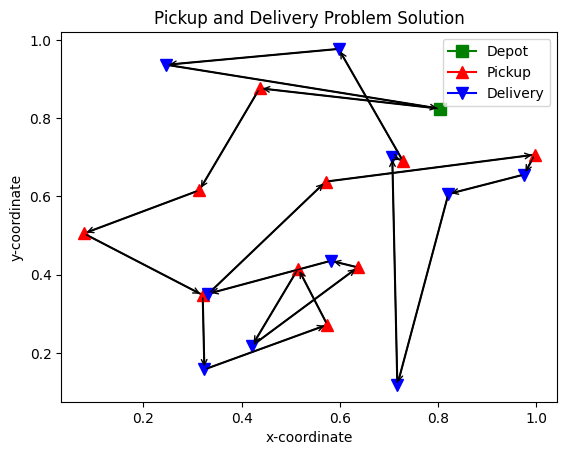

Reward: -6.394669055938721


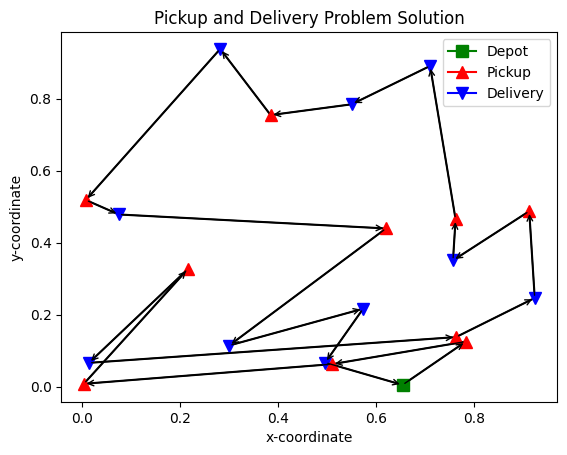

Reward: -5.147859573364258


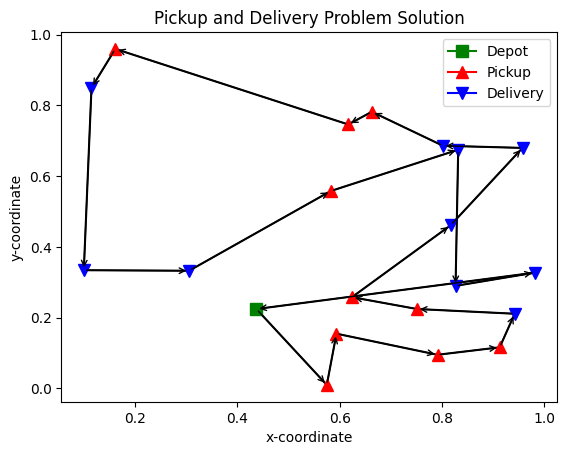

Reward: -5.096913814544678


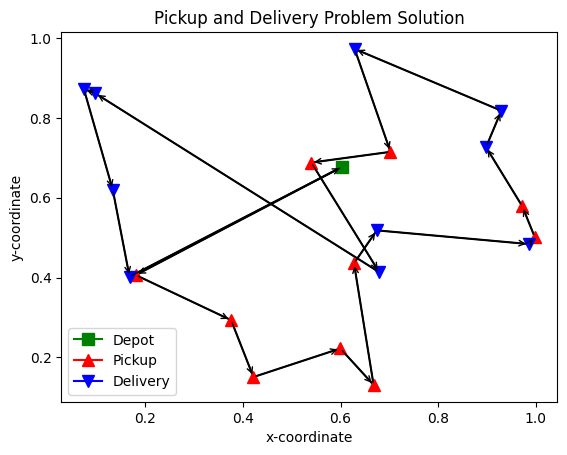

Reward: -4.671078681945801


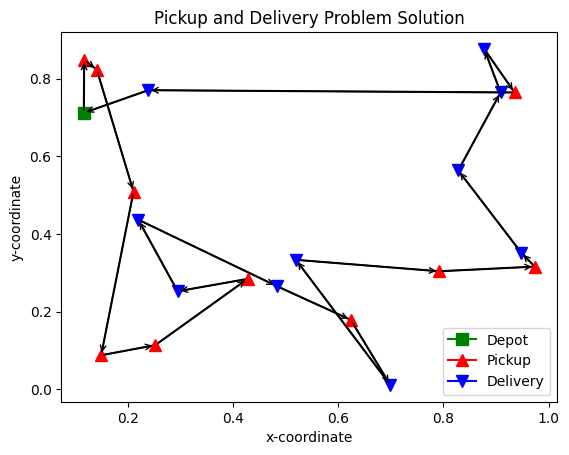

In [16]:
td.set('reward', out['reward'])
td.set('action', out['actions'])
for i in range(5):
    print("Reward:", td['reward'][i].item())
    env.render(td[i])